In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "9"

import sae_bench.custom_saes.custom_sae_config as custom_sae_config
import sae_bench.custom_saes.relu_sae as relu_sae
import sae_bench.custom_saes.run_all_evals_custom_saes as run_all_evals_custom_saes
import sae_bench.evals.core.main as core
import sae_bench.evals.sparse_probing.main as sparse_probing
import sae_bench.sae_bench_utils.general_utils as general_utils
from sae_bench.sae_bench_utils.sae_selection_utils import get_saes_from_regex

RANDOM_SEED = 42

output_folders = {
    "absorption": "eval_results/absorption",
    "autointerp": "eval_results/autointerp",
    "core": "eval_results/core",
    "scr": "eval_results/scr",
    "tpp": "eval_results/tpp",
    "sparse_probing": "eval_results/sparse_probing",
    "unlearning": "eval_results/unlearning",
}

# Note: Unlearning is not recommended for models with < 2B parameters and we recommend an instruct tuned model
# Unlearning will also require requesting permission for the WMDP dataset (see unlearning/README.md)
# Absorption not recommended for models < 2B parameters
# asyncio doesn't like notebooks, so autointerp must be ran using a python script

# Select your eval types here.
eval_types = [
    # "absorption",
    # "autointerp",
    "core",
    # "scr",
    # "tpp",
    "ravel",
    # "sparse_probing",
    # "unlearning",
]

if "autointerp" in eval_types:
    raise ValueError("autointerp must be ran using a python script")

device = general_utils.setup_environment()

model_name = "pythia-160m"
llm_batch_size = 512
torch_dtype = torch.float32

# Currently all evals take str_dtype instead of torch_dtype. We did this for serialization purposes, but it was probably a mistake.
# For now we will just use the str_dtype. TODO: Fix this
str_dtype = torch_dtype.__str__().split(".")[-1]


# If evaluating multiple SAEs on the same layer, set save_activations to True
# This will require at least 100GB of disk space
save_activations = False

Using device: cuda


This cell loads your custom SAEs. If you just want to use existing SAE Lens SAEs, comment it out.


In [4]:
# repo_id = "canrager/lm_sae"
# baseline_filename = (
#     "pythia70m_sweep_standard_ctx128_0712/resid_post_layer_4/trainer_8/ae.pt"
# )
# hook_layer = 4
# hook_name = f"blocks.{hook_layer}.hook_resid_post"

# sae = relu_sae.load_dictionary_learning_relu_sae(
#     repo_id, baseline_filename, model_name, device, torch_dtype, layer=hook_layer
# )

# print(f"sae dtype: {sae.dtype}, device: {sae.device}")

# d_sae, d_in = sae.W_dec.data.shape

# assert d_sae >= d_in

# print(f"d_in: {d_in}, d_sae: {d_sae}")

from sae_lens import SAE
llm_dtype = "float32"                       # must match your SAE cfg.dtype
llm_batch_size = 512

def load_sae(
    sae_dir,
):
    sae = SAE.load_from_pretrained(sae_dir, device=device, dtype=llm_dtype)

    # 3) fill in any missing cfg fields SAE Bench expects
    sae.cfg.dtype            = llm_dtype
    sae.cfg.architecture     = "standard"      # match how you trained it
    sae.cfg.training_tokens  = 512_000_000     # total tokens you trained on
    sae.cfg.hook_layer = 8
    sae.cfg.hook_name  = f"blocks.{sae.cfg.hook_layer}.hook_mlp_out"
    
    return sae

sae_set = {
    "5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8": {
        "sae_dir": "/data/zixuan/phd/sae/results/5.1-grid_l1-1_newinit-False_seed-1_gated/final_512000000",
        "custom_id": "5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8",
    },
    "5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8": {
        "sae_dir": "/data/zixuan/phd/sae/results/5.1-grid_l1-1_newinit-True_seed-1_gated/final_512000000",
        "custom_id": "5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8",
    },
}

selected_saes = []
for key in sae_set:
    sae_dir = sae_set[key]["sae_dir"]
    custom_id = sae_set[key]["custom_id"]

    # 1) load the SAE
    print(f"Loading SAE {key} from {sae_dir}")
    sae = load_sae(sae_dir)

    selected_saes.append((custom_id, sae))


Loading SAE 5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8 from /data/zixuan/phd/sae/results/5.1-grid_l1-1_newinit-False_seed-1_gated/final_512000000


/data/zixuan/miniconda3/envs/sae/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading SAE 5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8 from /data/zixuan/phd/sae/results/5.1-grid_l1-1_newinit-True_seed-1_gated/final_512000000


/data/zixuan/phd/sae/SAELens/sae_lens/sae.py:152: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In our sae object we need to have a CustomSAEConfig. This contains some information which is used by the evals (hook_name, hook_layer, model_name, d_sae, etc). In addition, it contains information that is used by our plotting functions, like number of training tokens and architecture. For example, we should have the sae.cfg.architecture defined if we want to plot multiple SAE architectures.

Note: Everything in this cell, except `architecture` and `training_tokens`, is done in the `BaseSAE` class that the `ReluSAE` inherits from. Because of this, we recommend that you modify an existing SAE class.


In [5]:
# sae.cfg = custom_sae_config.CustomSAEConfig(
#     model_name, d_in=d_in, d_sae=d_sae, hook_name=hook_name, hook_layer=hook_layer
# )

# # Core evals require us to specify cfg.dtype, which must be a string for easy serialization. TODO: Refactor to use torch.dtype
# sae.cfg.dtype = str_dtype


# The following contains our current defined SAE types and the shapes to plot for each. Add your custom SAE as new_sae_key
new_sae_key = "vanilla"
trainer_markers = {
    "standard": "o",
    "jumprelu": "X",
    "topk": "^",
    "p_anneal": "*",
    "gated": "d",
    new_sae_key: "s",  # New SAE
}

trainer_colors = {
    "standard": "blue",
    "jumprelu": "orange",
    "topk": "green",
    "p_anneal": "red",
    "gated": "purple",
    new_sae_key: "black",  # New SAE
}

# sae.cfg.architecture = new_sae_key
# sae.cfg.training_tokens = 200_000_000

`selected_saes` is a list of tuples of (unique_sae_id, sae object) OR (sae lens release, sae lens id). If it is a list of custom sae objects, then memory size will increase with the length of the list. This is especially important if the SAEs are large. If memory is a concern, I recommend calling the `run_eval()` function multiple times with lists of length 1, each list containing a new sae object.


In [6]:
# # Note: the custom_sae_id should be unique, as it is used for the intermediate results and final results file names

# unique_custom_sae_id = baseline_filename.replace("/", "_").replace(".", "_")
# print(f"sae_id: {unique_custom_sae_id}")

# # list of tuple of (sae_id, sae object)
# custom_saes = [(unique_custom_sae_id, sae)]

Select your baseline SAEs here. Refer to `sae_regex_selection.ipynb` for more regex patterns. We are going to get a topk SAE from the same layer.


In [7]:
# sae_regex_pattern = r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*"
# sae_block_pattern = r".*blocks\.([4])\.hook_resid_post__trainer_(8)$"

# baseline_saes = get_saes_from_regex(sae_regex_pattern, sae_block_pattern)
# print(f"baseline_saes: {baseline_saes}")
# baseline_sae_id = f"{baseline_saes[0][0]}_{baseline_saes[0][1]}".replace(".", "_")
# print(f"baseline_sae_id: {baseline_sae_id}")

# selected_saes = custom_saes + baseline_saes

Run time for the next 2 functions is approximately 2 minutes on an RTX 3090.


In [9]:
# Note: We typically run with n_eval_sparsity_variance_batches=2000, but I have reduced it here for a faster run

_ = core.multiple_evals(
    selected_saes=selected_saes,
    n_eval_reconstruction_batches=200,
    n_eval_sparsity_variance_batches=200,
    eval_batch_size_prompts=32,
    compute_featurewise_density_statistics=True,
    compute_featurewise_weight_based_metrics=True,
    exclude_special_tokens_from_reconstruction=True,
    dataset="Skylion007/openwebtext",
    context_size=128,
    output_folder="eval_results/core",
    verbose=True,
    dtype=str_dtype,
)

Running SAE evaluation on all selected SAEs:   0%|          | 0/2 [00:00<?, ?it/s]

Decoder weights are not normalized. Max diff: 4.734266757965088
Loaded pretrained model pythia-160m into HookedTransformer


/data/zixuan/phd/sae/SAELens/sae_lens/training/activations_store.py:301: UserWarning: Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.
  warnings.warn(
Sparsity and Variance Batches: 100%|██████████| 200/200 [00:22<00:00,  8.95it/s]
Failed to evaluate SAE custom_sae from 5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8 with context length 128 on dataset Skylion007/openwebtext: 'SAE' object has no attribute 'b_enc'
Running SAE evaluation on all selected SAEs:  50%|█████     | 1/2 [01:34<01:34, 94.22s/it]

Decoder weights are not normalized. Max diff: 1.474214792251587


Sparsity and Variance Batches: 100%|██████████| 200/200 [00:22<00:00,  8.99it/s]
Failed to evaluate SAE custom_sae from 5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8 with context length 128 on dataset Skylion007/openwebtext: 'SAE' object has no attribute 'b_enc'
Running SAE evaluation on all selected SAEs: 100%|██████████| 2/2 [03:08<00:00, 94.29s/it]


In [ ]:
import sae_bench.evals.sparse_probing.main as sparse_probing
import sae_bench.evals.ravel.main as ravel
import sae_bench.evals.absorption.main as absorption
import sae_bench.evals.autointerp.main as autointerp
import sae_bench.evals.scr_and_tpp.main as scr_and_tpp
import sae_bench.evals.unlearning.main as unlearning

ravel.multiple_evals(
    selected_saes=selected_saes,
    n_eval_reconstruction_batches=200,
    n_eval_sparsity_variance_batches=200,
    eval_batch_size_prompts=32,
    compute_featurewise_density_statistics=True,
    compute_featurewise_weight_based_metrics=True,
)

In [14]:
# We do a subset of the sparse probing datasets here for shorter runtime
dataset_names = ["LabHC/bias_in_bios_class_set1"]
# Set CUDA_VISIBLE_DEVICES to use GPU 9

os.environ["CUDA_VISIBLE_DEVICES"] = "8"

# TODO: Add a verbose flag
_ = sparse_probing.run_eval(
    sparse_probing.SparseProbingEvalConfig(
        model_name=model_name,
        random_seed=RANDOM_SEED,
        llm_batch_size=llm_batch_size,
        llm_dtype=str_dtype,
        dataset_names=dataset_names,
    ),
    selected_saes,
    device,
    "eval_results/sparse_probing",
    force_rerun=False,
    clean_up_activations=True,
    save_activations=save_activations,
)

Loaded pretrained model pythia-160m into HookedTransformer


Running SAE evaluation on all selected SAEs: 100%|██████████| 2/2 [00:00<00:00, 950.44it/s]

Decoder weights are not normalized. Max diff: 4.734266757965088
Skipping 5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8_custom_sae as results already exist
Decoder weights are not normalized. Max diff: 1.474214792251587
Skipping 5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8_custom_sae as results already exist


In [15]:
import json

import torch

import sae_bench.sae_bench_utils.graphing_utils as graphing_utils


In [16]:
image_path = "./images"

if not os.path.exists(image_path):
    os.makedirs(image_path)

In [17]:
results_folders = ["./eval_results"]

eval_type = "sparse_probing"

eval_folders = []
core_folders = []
for results_folder in results_folders:
    eval_folders.append(f"{results_folder}/{eval_type}")
    core_folders.append(f"{results_folder}/core")

eval_filenames = graphing_utils.find_eval_results_files(eval_folders)
core_filenames = graphing_utils.find_eval_results_files(core_folders)

print(f"eval_filenames: {eval_filenames}")
print(f"core_filenames: {core_filenames}")

eval_filenames: ['./eval_results/sparse_probing/standard_l1-2.0_newinit-False_custom_sae_eval_results.json', './eval_results/sparse_probing/standard_l1-2.0_newinit-True_custom_sae_eval_results.json', './eval_results/sparse_probing/5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8_custom_sae_eval_results.json', './eval_results/sparse_probing/5.1-grid_l1-1_newinit-True_seed-1_gated_pythia-160m_8_custom_sae_eval_results.json']
core_filenames: ['./eval_results/core/standard_l1-2.0_newinit-False_custom_sae_eval_results.json', './eval_results/core/standard_l1-2.0_newinit-True_custom_sae_eval_results.json']


Here we can view the raw results, and we see that both SAEs significantly outperform the residual stream baseline.


In [18]:
eval_results_dict = graphing_utils.get_eval_results(eval_filenames)
core_results_dict = graphing_utils.get_eval_results(core_filenames)

print(eval_results_dict)
print(core_results_dict)
for sae in eval_results_dict:
    eval_results_dict[sae].update(core_results_dict[sae])


print(eval_results_dict.keys())

{'standard_l1-2.0_newinit-False_custom_sae': {'sae_test_accuracy': 0.9310000538825989, 'sae_top_1_test_accuracy': 0.6924, 'sae_top_2_test_accuracy': 0.7205999999999999, 'sae_top_5_test_accuracy': 0.7836000000000001, 'sae_top_10_test_accuracy': None, 'sae_top_20_test_accuracy': None, 'sae_top_50_test_accuracy': None, 'sae_top_100_test_accuracy': None, 'eval_config': {'random_seed': 42, 'dataset_names': ['LabHC/bias_in_bios_class_set1'], 'probe_train_set_size': 4000, 'probe_test_set_size': 1000, 'context_length': 128, 'sae_batch_size': 125, 'llm_batch_size': 512, 'llm_dtype': 'float32', 'model_name': 'pythia-160m', 'k_values': [1, 2, 5], 'lower_vram_usage': False}, 'sae_class': 'standard', 'd_sae': '32k', 'train_tokens': 1e-06}, 'standard_l1-2.0_newinit-True_custom_sae': {'sae_test_accuracy': 0.9354000449180603, 'sae_top_1_test_accuracy': 0.7070000000000001, 'sae_top_2_test_accuracy': 0.7592000000000001, 'sae_top_5_test_accuracy': 0.8203999999999999, 'sae_top_10_test_accuracy': None, 'sa

KeyError: '5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8_custom_sae'

In [19]:
baseline_filepath = eval_filenames[0]

with open(baseline_filepath) as f:
    baseline_sae_eval_results = json.load(f)

custom_filepath = eval_filenames[1]

with open(custom_filepath) as f:
    custom_sae_eval_results = json.load(f)

k = 1

print(baseline_sae_eval_results.keys())

print(
    f"Baseline SAE top {k} accuracy was:",
    baseline_sae_eval_results["eval_result_metrics"]["sae"][
        f"sae_top_{k}_test_accuracy"
    ],
)
print(
    f"Custom SAE top {k} accuracy was:",
    custom_sae_eval_results["eval_result_metrics"]["sae"][f"sae_top_{k}_test_accuracy"],
)
print(
    f"LLM residual stream top {k} accuracy was:",
    baseline_sae_eval_results["eval_result_metrics"]["llm"][
        f"llm_top_{k}_test_accuracy"
    ],
)

dict_keys(['eval_type_id', 'eval_config', 'eval_id', 'datetime_epoch_millis', 'eval_result_metrics', 'eval_result_details', 'sae_bench_commit_hash', 'sae_lens_id', 'sae_lens_release_id', 'sae_lens_version', 'sae_cfg_dict', 'eval_result_unstructured'])
Baseline SAE top 1 accuracy was: 0.6924
Custom SAE top 1 accuracy was: 0.7070000000000001
LLM residual stream top 1 accuracy was: 0.6364


We can also plot the metrics, plotting L0 vs Custom Metric or L0 vs Loss Recovered vs Custom metric. We can have different shapes for the SAE type or dictionary size.


In [20]:
image_base_name = os.path.join(image_path, "sparse_probing")

graphing_utils.plot_results(
    eval_filenames,
    core_filenames,
    eval_type,
    image_base_name,
    k,
    trainer_markers=trainer_markers,
    trainer_colors=trainer_colors,
)

KeyError: '5.1-grid_l1-1_newinit-False_seed-1_gated_pythia-160m_8_custom_sae'

Now we will run all of the evals, and create more plots. Be warned - this takes around an hour. Note that a significant amount of the costs are one time per layer - for example, with absorption, we have to train a bunch of probes on a given layer. So, if we have multiple SAEs per layer the cost should be much less than 30 minutes per SAE. In addition, to save disk space usage we currently are not saving activations for reuse by multiple SAEs.

Additionally, we can make this faster by evaluating on a subset of the datasets. Sparse probing and Spurious Correlation Removal both have approximately 8 datasets each. We could lower the time by using fewer datasets at the cost of not having as strong of a signal.


In [1]:
_ = run_all_evals_custom_saes.run_evals(
    model_name,
    selected_saes,
    llm_batch_size,
    str_dtype,
    device,
    eval_types,
    api_key=None,
    force_rerun=False,
    save_activations=save_activations,
)

NameError: name 'run_all_evals_custom_saes' is not defined

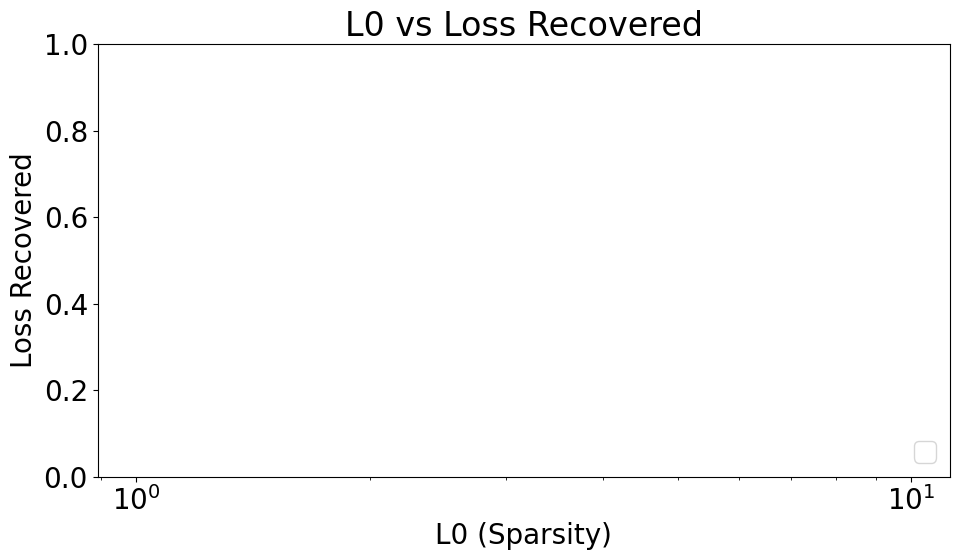

ValueError: Please add the correct key for the custom metric

In [23]:
for eval_type in eval_types:
    eval_folders = []

    for results_folder in results_folders:
        eval_folders.append(f"{results_folder}/{eval_type}")

    eval_filenames = graphing_utils.find_eval_results_files(eval_folders)

    graphing_utils.plot_results(
        eval_filenames,
        core_filenames,
        eval_type,
        image_base_name,
        k=10,
        trainer_markers=trainer_markers,
        trainer_colors=trainer_colors,
    )